# Algorithm - Density Based Spatial Clustering of Applications with Noise
1. 3 kinds of points: core points, border points, noise points
2. 2 hyperparameters to tune: $\epsilon$, `min_points`
3. <u>Core:</u> a point that has at least `min_points` no. of points in a radius of $\epsilon$ around it.
4. <u>Border:</u> a point that doesn't even have `min_points` no. of points in a radius of $\epsilon$ around it, **but** has at-least 1 core point in its $\epsilon$ radius.
5. <u>Noise:</u> all non-core, non-border points
6. <u>Density connected points:</u> points which are connected to each other **indirectly** by a path of **core points** where each consecutive core-point-pair of this path is at most separated by $\epsilon$ distance.
6. **Step-1:** Label all samples of the dataset to be clustered as core or border or noise.
7. **Step-2:** For all unclustered core points
    1. create a brand new cluster with only the current core point.
    2. add all unclustered points that are density-connected to this core point to its cluster.
8. **Step-3:** For each unclustered border point, assign to the cluster of the nearest core point.
9. **Step-4:** Leave noise points as they are.

In [3]:
import numpy as np

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [37]:
class myDBSCAN:
    def __init__(self, eps, min_points):
        self.eps = eps
        self.min_points = min_points
        self.adj_list = None                               # filled using method init_adj_mat()
        self.point_categories = None
        self.clusters = None
        self.density_connections = None
    def init_adj_list(self, X: np.ndarray):
        n_points = X.shape[0]
        self.adj_list = [[] for _ in range(n_points)]
        for u in range(n_points):
            n_points_hood = 0
            for v in range(n_points):
                if v != u:
                    d_uv = np.linalg.norm(X[u]-X[v])
                    if d_uv <= self.eps:
                        self.adj_list[u].append(v)
                        n_points_hood += 1
            if n_points_hood >= self.min_points:           # found a core point
                self.point_categories[u] = 2
        
        # identify all border points
        for u in range(n_points):
            if self.point_categories[u] != 2:              # only consider a non-core point
                for v in self.adj_list[u]:
                    if self.point_categories[v] == 2:
                        self.point_categories[u] = 1       # at least 1 core-point connected by an edge found, 
                        break                              # making the current point 'u' a border point

    def establish_density_connections(self, X: np.ndarray):
        n_points = X.shape[0]
        vis_arr = [False]*n_points
        for u in range(n_points):
            if self.point_categories[u] == 2 and not vis_arr[u]: # core point + not yet visited during BFS
                bfs_q = self.adj_list[u]
                vis_arr[u] = True
                while bfs_q:
                    pt = bfs_q.pop()
                    vis_arr[pt] = True
                    self.density_connections[u][pt] = True
                    self.density_connections[pt][u] = True
                    if self.point_categories[pt] == 2:
                        for v in self.adj_list[pt]:
                            if not vis_arr[v]:
                                bfs_q.append(v)

    def clusterize_points(self, X: np.ndarray):
        n_points = X.shape[0]
        self.clusters = [-1]*n_points                      # all points are unclustered at the beginning
        cluster_idx = 0                                    # first cluster
        for u in range(n_points):
            if self.point_categories[u] == 2 \
                and self.clusters[u] == -1:                # unclustered core-point
                self.clusters[u] = cluster_idx
                cluster_idx += 1

                # add all density connected points to this cluster
                for v in range(n_points):
                    if self.density_connections[u][v] \
                        and self.clusters[v] == -1:
                        self.clusters[v] = self.clusters[u]
        for u in range(n_points):
            if self.point_categories[u] == 1 and self.clusters[u] == -1:
                # unclustered border-point

                d_max = 10000000
                for v in range(n_points):
                    if self.point_categories[v] == 2:
                        dist = np.linalg.norm(X[v, :] - X[u, :])
                        if d_max > dist:
                            self.clusters[u] = self.clusters[v]



    def fit(self, X: np.ndarray):
        # noise point: category = 0
        # border point: category = 1
        # core point: category = 2

        self.point_categories = np.zeros(X.shape[0])
        self.density_connections = np.zeros((X.shape[0], X.shape[0]))

        self.init_adj_list(X)
        self.establish_density_connections(X)
        self.clusterize_points(X)
        
        return self.clusters

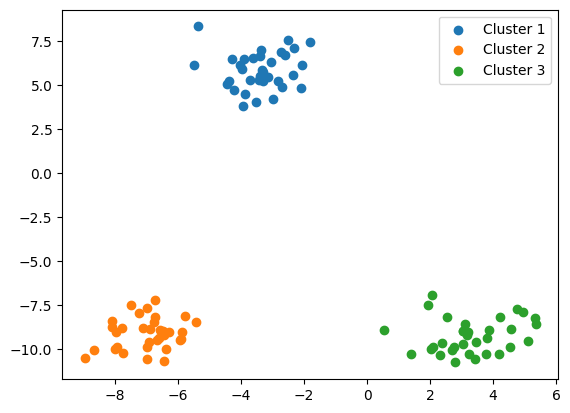

In [7]:
X, y = make_blobs()
for cluster_idx in np.unique(y):
    plt.scatter(X[y == cluster_idx, 0], X[y == cluster_idx, 1], label=f'Cluster {cluster_idx+1}')
plt.legend()
plt.show()

In [43]:
def cluster_constituents(point_wise_clusters):
    cluster_names = sorted(list(set(point_wise_clusters)))
    cluster_name2idx = {
        elem: idx
        for idx, elem in enumerate(cluster_names)
    }
    ans = [[] for _ in cluster_names]
    for pt_idx in range(len(point_wise_clusters)):
        cluster_name = cluster_name2idx[point_wise_clusters[pt_idx]]
        ans[cluster_name].append(pt_idx)
    return ans

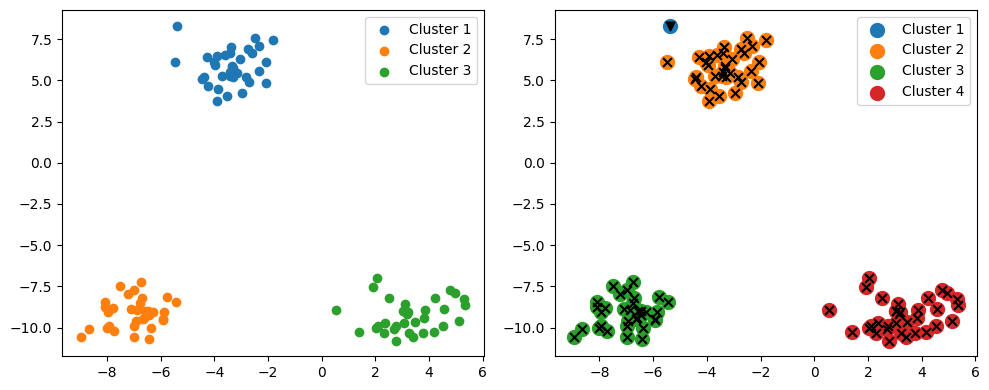

In [44]:
dbscan_clusterer = myDBSCAN(eps = 2, min_points=3)
dbscan_clusters = cluster_constituents(dbscan_clusterer.fit(X))

marker_dict = {
    0: 'v',
    1: '+',
    2: 'x'
}

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for cluster_idx in np.unique(y):
    ax[0].scatter(X[y == cluster_idx, 0], X[y == cluster_idx, 1], label=f'Cluster {cluster_idx+1}')
for cluster_idx in range(len(dbscan_clusters)):
    if dbscan_clusters[cluster_idx]:
        ax[1].scatter(
            X[dbscan_clusters[cluster_idx], 0], 
            X[dbscan_clusters[cluster_idx], 1], 
            label=f'Cluster {cluster_idx+1}',
            s=100
        )
for pt in range(X.shape[0]):
    ax[1].scatter(X[pt, 0], X[pt, 1], marker=marker_dict[dbscan_clusterer.point_categories[pt]], c='k', s=40)
    # ax[1].scatter(X[pt, 0], X[pt, 1], marker='x', c='k', s=40)

ax[0].legend();ax[1].legend()
plt.tight_layout()

plt.show()

# How to tune the hyperparameters $\epsilon$ and `min_points`?

# Problems
1. Euclidean distance inadequate for higher dimensional data, use Cosine(cosine distance = 1 - cosine similarity, cosine similarity = $cos(\theta)$ between 2 vectors) or Manhattan distance instead
    1. for the same euclidean distance value, in 2d that value would mean physically separating the points much more than in say 3d, which will be more than 4d and so on....
    2. this is called **concentration of distances**.
2. will struggle with varying density clusters
    1. because of using a constant $\epsilon$ value , some clusters will be dense and be labelled as a single cluster
    2. but others that may have a naturally higher $\epsilon$ value may not satisfy this constant $\epsilon$ value used while clustering and could be partitioned into multiple clusters